# Assignment 2: Text Representation & Text Similarity

Hello everyone, this assignment notebook covers **Text Representation** and **Text Similarity**. There are some code-completion tasks and some questions in this notebook. For each code completion task, please write down your answer (i.e., your lines of code) between sentences that `Your code starts here` and `Your code ends here`. The space between these two lines does not reflect the required or expected lines of code.

When you work on this notebook, you can insert additional code cells (e.g., for testing) or markdown cells (e.g., to keep track of your thoughts). However, before the submission, please remove all those additional cells again. Thanks!

**Important:** 
* Remember to rename and save this Jupyter notebook as **A2_YourName_YourNUSNETID.ipynb** (e.g., **A2_BobSmith_e12345678.ipynb**) before submission!
* Remember to rename and save the script file **A2.py** as **A2_YourName_YourNUSNETID.py** (e.g., **A2_BobSmith_e12345678.py**) before submission!
* Submission deadline is Tuesday, Mar 5, 11.59 pm. Late submissions will be penalized by 10% for each additional day.
<!-- * **Do not change any predefined variable names!** For example in Task 1.1 a), you need to find the correct RegEx as value for the variable named `pattern_11a`; do not change this variable name! -->

Please also add your NUSNET and student id in the code cell below. This is just to make any identification of your notebook doubly sure.

In [1]:
student_id = 'A0286188L'
nusnet_id = 'E1237250'

Here is an overview over the tasks to be solved and the points associated with each task. The notebook can appear very long and verbose, but note that a lot of parts are there to provide additional explanations, documentation, or some discussion. The code and markdown cells you are supposed to complete are well marked, but you can use the overview below to double-check that you covered everything.

* **1 TF-IDF Vectorization (15 Points)**
    * 1.1 Hand-Crafted Features (3 Points)
    * 1.2 Basic Implementation of a TF-IDF Vectorizer (6 Points)
        * 1.2 a) Calculating IDF Weights (3 Points)
        * 1.2 b) Generating Document Vectors (3 Points)
    * 1.3 N-Gram Support (6 Points)
        * 1.3 a) Computing Corpus N-Grams (3 Points)
        * 1.3 b) Upper Bound for the Number of N-Grams (3 Points)
* **2 K-Nearest Neighbor (15 Points)**
    * 2.1 Implementation of K-Nearest Neighbor Classifier (8 Points)
        * 2.1 a) Calculate Pairwise Distances (4 Points)
        * 2.2 b) Predict Class Labels (4 Points)
    * 2.2 Questions (7 Points)
        * 2.2 a) Comparison with "Pure" scitkit-learn Solution (4 Points)
        * 2.2 b) Hyperparameter Tuning (3 Points)
* **3 Clustering & AGNES (20 Points)**
    * 3.1 Implementing AGNES (10 Points)
        * 3.1 a) Calculating the Distances between 2 Clusters (2 Points)
        * 3.1 b) Generating the Distance Matrix (3 Points)
        * 3.1 c) Find all Clusterings (5 Points)
    * 3.2 Questions about Clustering (9 Points)
        * 3.2 a) Comparing AGNES Linkage Methods (3 Points)
        * 3.2 b) Questions about K-Means (7 Points)

### Notebook Setup

The following code cell ensures that the `.py` file gets automatically reloaded after you save any changes.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import re, json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

np.set_printoptions(precision=2)

# Auxiliary code for generating plots (feel free to have a look)
from src.utils import plot_agnes_clustering

ModuleNotFoundError: No module named 'src'

**Important:** This notebook also requires you to complete in a separate `.py` script file. This keeps this notebook cleaner and simplifies testing your implementations for us. As you need to rename the file `A2.py`, you also need to edit the import statement below accordingly.

In [4]:
from A2_VishwanathDattatreyaDoddamani_e1237250 import MyTfidfVectorizer, MyAgglomerativeClustering, MyKNeighborsClassifier, euclidean_distances
#from A2_BobSmith_e12345678 import MyTfidfVectorizer, MyAgglomerativeClustering, MyKNeighborsClassifier, euclidean_distances

### Dataset Preparation

Throughout this notebook, we will use the same toy corpus -- already in the preprocessing form -- we used in the lecture. This allows us to directly compare the result with the lecture slides. And given its tiny size, there will be no worries regarding runtime issues :).

In [5]:
toy_corpus, toy_labels = [], []

with open("data/a2-toy-corpus-preprocessed.txt") as file:
    for line in file:
        sentence, label = line.strip().split("\t")
        toy_corpus.append(sentence.split())
        toy_labels.append(label)

y_toy_train = np.array(toy_labels)        
        
for doc in toy_corpus:
    print(doc)

['mayor', 'elect', 'term', 'term']
['mayor', 'goal', 'term', 'win']
['goal', 'term', 'win', 'vote']
['term', 'goal', 'term', 'goal']
['goal', 'team', 'player', 'win']
['win', 'team', 'win', 'player']
['player', 'vote', 'player', 'term']


---

## 1 Feature Extraction (Document Vectorization)

We saw that, from the perspective of working with and analyzing it, text is not really convenient data. Text documents can generally be of arbitrary length, and words/tokens -- as the important meaningful building blocks -- are only nominal data. Or simply speaking, words are just labels, at least to a machine or algorithm. However, most techniques and algorithms for text mining methods require input to be numerical and of a fixed size. This is where the notion of *feature extractions* or *document vectorization* come in. The fundamental goal is to convert each text document in a corpus into a fixed-size vector, with the vector elements being numeric and their values set in such a way that they represent some characteristics of the document in a meaningful way.

### 1.1 Hand-Crafted Features (4 Points)

One alternative we mentioned was the "manual" identification and extraction of handcrafted features. Here, we have to decide which numeric characteristics we deem meaningful for a given text mining task. In the lecture, we used the task of Sentiment Analysis as an example and considered features such as the length of a document, the number of positive/negative emoticons, the number of positive/negative words, etc. So as a warm-up exercise let's implement the extraction of hand-crafted features for a very simple Sentiment Analysis setup. To keep it simple, we want to extract the following features:

* Number of all characters
* Number of non-whitespace characters in the text
* Number of uppercase words (e.g., "NICE", "HAPPY")
* Number of "positive" words (e.g., "happy", "great")
* Number of "negative" words (e.g., "lonely", "sad")
* Number of exclamation marks

Regarding the list of "positive" and "negative" words, there are many comprehensive word lists publicly available for download. To keep it simple, we assume the following two lists with "positive" and "negative" words. Additionally, we can utilize a word list that contains common Internet slang.

In [6]:
WORDLIST_POSITIVE = ['happy', 'great', 'nice', 'awesome', 'joyful']
WORDLIST_NEGATIVE = ['sad', 'horrible', 'boring', 'lonely', 'cruel']

WORDLIST_SLANG = ['lol', 'rofl', 'lmao', 'wtf', 'ftw', 'imo']

**Task: Implement the method `extract_features()` below to extract all required features from a text document.** To illustrate the basic idea -- and because it's too trivial anyway :) -- we already provide you with a snippet to calculate the total number of characters.

**Comments & Hints:**

* All features can be extracted using Regular Expression. With your practice in writing Regular Expression, this should be a very simple task. However, you are not required to use Regular Expressions and can use any in-built method provided by Python to solve this task.
* If you use Regular Expression, we recommend always using `flags=re.I` or `flags=re.IGNORECASE` to ensure that all your matches are insensitive to the case of the words. If you don't use Regular Expression, you need to handle the case of words differently.

In [7]:
def extract_features(text):
    
    features = {
        "num_chars": 0,                # total length of text incl. all characters
        "num_nonwhite_characters": 0,  # number of non-whitespace characters
        "num_uppercase_words": 0,      # number of words in all uppercase (e.g., "NICE", "HAPPY")
        "num_positive_words": 0,       # number of positive words
        "num_negative_words": 0,       # number of negatice words
        "num_slang_words": 0,          # number of slang words        
        "num_exclamation_marks": 0,    # number of exclamation marks
    }
    
    features["num_chars"] = len(text)
    
    #########################################################################################
    ### Your code starts here ###############################################################
    nonWhite = text.strip()
    nonWhite = text.split()
    nonWhite = ''.join(nonWhite)
    features["num_nonwhite_characters"] = len(nonWhite)
    
    uppercaseWords = text.split()
    countUpperCaseWords = 0
    countPositiveWords = 0
    countNegativeWords = 0
    countSlangWords = 0
    for word in uppercaseWords:
        if word.isupper():
            countUpperCaseWords += 1
    for word in WORDLIST_POSITIVE:
        countPositiveWords += text.lower().count(word)
    for word in WORDLIST_NEGATIVE:
        countNegativeWords += text.lower().count(word)
    for word in WORDLIST_SLANG:
        countSlangWords += text.lower().count(word)

    features["num_uppercase_words"] = countUpperCaseWords
    features["num_positive_words"] = countPositiveWords
    features["num_negative_words"] = countNegativeWords
    features["num_slang_words"] = countSlangWords
    features["num_exclamation_marks"] = text.count('!')
    ### Your code ends here #################################################################
    #########################################################################################
    
    return features


features = extract_features("WTF!! Such a nice movie!!! It made me both HAPPY and SAD...")

# Copy Paste this example for marking (feel free to modify)
#features = extract_features("!!! TEST! sad saddle imo limo HAPPY CHAPPY BORING!!")

# We use the json package only for printing the dictionary a bit nicer
print(json.dumps(features, indent=2))

{
  "num_chars": 59,
  "num_nonwhite_characters": 48,
  "num_uppercase_words": 3,
  "num_positive_words": 2,
  "num_negative_words": 1,
  "num_slang_words": 1,
  "num_exclamation_marks": 5
}


The expected output for the code cell above is:

```
{
  "num_chars": 59,
  "num_nonwhite_characters": 48,
  "num_uppercase_words": 3,
  "num_positive_words": 2,
  "num_negative_words": 1,
  "num_slang_words": 1,
  "num_exclamation_marks": 5
}
```

I think you can acknowledge that we picked only features that are very easy to extract. In practice, of course, this can get arbitrarily more tricky. For example, consider we also want to extract the number of positive and negative emoticons. This would either require a comprehensive list of common emoticons, or a smart Regular Expression to match emoticons. Or maybe we want to count words to `num_uppercase_words` if more than half of the letters in the word are capitalized; again, which would make it a bit more complicated. Other features might include the information about Post-of-Speech tags (e.g., the number of nouns, verbs, and adjectives). Again, here we kept it very simple to get you warmed-up for the assignment :).

### 1.2 Basic Implementation of a TF-IDF Vectorizer (8 points)

The challenges with hand-crafted features are (a) that we have to identify which features might be useful, and (b) that we actually need to extract them from each text document. This also includes that our choice of features typically depends on the specific task. For example for clustering news articles, we probably have no need to extract the number of positive and negative emoticons.

The motivation behind the Vector Space Model is to provide a more generalized method for feature extraction. Here the extracted features directly derive from the vocabulary which makes this representation task-independent. On the other hand, using the vocabulary as features set also means that the size of each document vectors is the size of the vocabulary, and that in practice most elements in a document vector are 0 (i.e., VSM document vectors are sparse vectors; we talked about the limitations a bit in the lecture). While the general output of the transformation of a corpus is the Term-Document Matrix, the exact values in the matrix depend on the choice of representation. Since the TF-IDF weights are by far the most common choice for the matrix values, this is what will be implemented in this section.

You can find the skeleton code of `MyTfidfVectorizer` class in the `.py` file. The method and parameter names as well as the output are designed by mimic the input and output of the [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). There are only some minor differences to consider, which will point where needed but make the implementation actually a bit easier.

#### 1.2 a) Calculating IDF Weights (4 Points)

Fitting the `MyTfidfVectorizer` means to compute the Inverse Document Frequency (IDF) weights for each term in the vocabulary, which means that we also need to generate the vocabulary from the text corpus. Note that we only need to compute the term frequencies (TF) when we actually transform documents into their respective document vectors

**Task: Implement the method `fit()` to calculate the IDF weights!** This implicitly requires calculating the vocabulary, where the vocabulary refers to the number of unique words/tokens in the corpus. Please use the formula from the lecture slides (incl. the use of $\log_{10}$) to yield the same result as seen on the slides.

**Note:** While the [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) assumes a list of strings as input by default, `MyTfidfVectorizer().fit()` requires a list of word lists. In other words, the documents/string have already been tokenized. The scitkit-learn `TfidfVectorizer` supports this as well, but requires explicit input parameter settings (see later in the notebook an example).

In [8]:
my_tfidf_vectorizer = MyTfidfVectorizer().fit(toy_corpus)

print("Vocabulary (lexicographically sorted):")
print(my_tfidf_vectorizer.get_feature_names_out().tolist())
print()
print("IDF values for some selected terms")
print("{}: {:.3f}".format("team", my_tfidf_vectorizer.idf["team"]))
print("{}: {:.3f}".format("goal", my_tfidf_vectorizer.idf["goal"]))

Vocabulary (lexicographically sorted):
['elect', 'goal', 'mayor', 'player', 'team', 'term', 'vote', 'win']

IDF values for some selected terms
team: 0.544
goal: 0.243


The expected output of the code cell above is:

```
Vocabulary (lexicographically sorted):
['elect', 'goal', 'mayor', 'player', 'team', 'term', 'vote', 'win']

IDF values for some selected terms
team: 0.544
goal: 0.243
```

#### 1.2 b) Generating Document Vectors (4 Points)

Now that we have the IDF weights for each term in our vocabulary, we have everything in place to vectorize our documents.

**Task: Implement the method `transform()` to generate the TF-IDF document vectors!** Again, consider the formula we used in the lectures and "dampen" the term frequency $tf_{t,d}$ for a word/term $t$ using: $(1 + \log_{10}tf_{t,d})$, if $tf_{t,d} > 0$, otherwise $0$. Please also take note of the minor difference compared to the definitions on the lecture slides:
* All scikit-learn vectorizers return a Document-Term Matrix, which is the same as the Term-Document Matrix but transposed. In order to use `MyTfidfVectorizer` as drop-in replacement for `TfidfVectorizer`, your `transform()` method should also return a Document-Term Matrix. Which means that the rows represent the documents, and the columns represent the features/word/tokens.

In [9]:
my_tfidf_vectorizer = MyTfidfVectorizer().fit(toy_corpus)

X_toy_train = my_tfidf_vectorizer.transform(toy_corpus)

# Print transposed matrix (Document-Term Matrix ==> Term-Document Matrix)
# Just to match the output to the example used on the lecture slides!
print(X_toy_train.T)

[[0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   0.24 0.24 0.32 0.24 0.   0.  ]
 [0.54 0.54 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.37 0.37 0.48]
 [0.   0.   0.   0.   0.54 0.54 0.  ]
 [0.19 0.15 0.15 0.19 0.   0.   0.15]
 [0.   0.   0.54 0.   0.   0.   0.54]
 [0.   0.24 0.24 0.   0.24 0.32 0.  ]]


The output of the code cell above should match the example we used in the lecture.

Since all scikit-learn vectorizers also offer a `fit_transform()` method to combine both steps, `MyTfidfVectorizer` also features this method. Of course, there is nothing for you to implement here since the method simply calls first `fit()` and then `transform()` on the same data. you can run the code cell below for an example, which naturally should yield the exact same output.

In [10]:
my_tfidf_vectorizer = MyTfidfVectorizer()

X_toy_train = my_tfidf_vectorizer.fit_transform(toy_corpus)

# Print transposed matrix (Document-Term Matrix ==> Term-Document Matrix)
# Just to match the output to the example used on the lecture slides!
print(X_toy_train.T)

[[0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   0.24 0.24 0.32 0.24 0.   0.  ]
 [0.54 0.54 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.37 0.37 0.48]
 [0.   0.   0.   0.   0.54 0.54 0.  ]
 [0.19 0.15 0.15 0.19 0.   0.   0.15]
 [0.   0.   0.54 0.   0.   0.   0.54]
 [0.   0.24 0.24 0.   0.24 0.32 0.  ]]


With your implementation of the method `transform()` we can now also transform new documents that have not been in the corpus used for training. The steps performed are, of course, exactly the same, but appreciate how we use the Term Frequencies from the unseen documents and the Inverse Document Frequencies from the training vocabulary to calculate the TF-IDF weights. This also means that an unseen document may contain words that were not in the vocabulary in the training corpus. In this case, simply speaking, the vectorizer ignores unknown terms. In the code cell below, we transform 3 documents. Note that the last document contains the term *"cs5246"* which is not represented in our Document-Term Matrix.

In [11]:
toy_corpus_test = [
    "mayor team term".split(),
    "goal win player".split(),
    "mayor cs5246 goal".split(),
]

X_toy_test = my_tfidf_vectorizer.transform(toy_corpus_test)

# Print transposed matrix (Document-Term Matrix ==> Term-Document Matrix)
print(X_toy_test.T)

[[0.   0.   0.  ]
 [0.   0.24 0.24]
 [0.54 0.   0.54]
 [0.   0.37 0.  ]
 [0.54 0.   0.  ]
 [0.15 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.24 0.  ]]


Notice that the last column only contains 2 values, representing the words *"mayor"* and *"goal"*. Since the vectorizer hasn't seen *"cs5246"* during training, this term is not represented in the matrix. If we would replace the unknown term *"cs5246"* with a known term (e.g., *"player"*), then we would of course see all 3 terms represent the respective document vector. The code cell below illustrates this.

In [12]:
toy_corpus_test = [
    "mayor team term".split(),
    "goal win player".split(),
    "mayor player goal".split(),
]

X_toy_test = my_tfidf_vectorizer.transform(toy_corpus_test)

# Print transposed matrix (Document-Term Matrix ==> Term-Document Matrix)
print(X_toy_test.T)

[[0.   0.   0.  ]
 [0.   0.24 0.24]
 [0.54 0.   0.54]
 [0.   0.37 0.37]
 [0.54 0.   0.  ]
 [0.15 0.   0.  ]
 [0.   0.   0.  ]
 [0.   0.24 0.  ]]


### 1.3 N-Gram Support (6 Points)

So far, we only considered individual words (i.e., unigrams) as features for the document vectors. However, we saw in the lecture that we can directly extend the Vector Space Model to n-grams of sizes larger than 1. This means that our vocabulary, and hence our set of features, now can also contain contiguous sequences of terms from a text. At this point it becomes handy that your `fit()` and `transform()` methods expect a list of word lists, as a word list may contain n-grams (and not just unigrams). As such, there is no need for any changes to `MyTfidfVectorizer`! Of course, we have to prepare our corpus to now also contain n-grams of sizes larger than 1 (if needed).

#### 1.3 a) Computing Corpus N-Grams (3 Points)

**Task: Implement the method `extract_ngrams()` below to compute all n-grams for a given word list and choice of n-gram range!** This should be a very simple task and not require any methods from additional packages such as `re`, `numpy`, `sklearn`. It's all about basic handling of Python lists.


In [13]:
def extract_ngrams(word_list, ngram_range=(1,1)):
    ngrams = []
    
    #########################################################################################
    ### Your code starts here ###############################################################    
    ngram_range_min = ngram_range[0]
    ngram_range_max = ngram_range[1]
    for i in range(ngram_range_min, ngram_range_max + 1):
        for j in range(len(word_list)):
            if j+i <= len(word_list):
                ngrams.append(' '.join(word_list[j:j+i]))
    ### Your code ends here #################################################################
    #########################################################################################            
            
    # Return ngrams (note: the order does no matter)
    return ngrams

# Run method over first sentence of our toy corpus
print(extract_ngrams(toy_corpus[0], ngram_range=(1,3)))

['mayor', 'elect', 'term', 'term', 'mayor elect', 'elect term', 'term term', 'mayor elect term', 'elect term term']


The expected output for the code cell above is:

```
['mayor', 'elect', 'term', 'term', 'mayor elect', 'elect term', 'term term', 'mayor elect term', 'elect term term']
```

Of course, this assumes `ngram_range=(1,3)`  as input parameter. You are encouraged to change those values to see if the output meets your expectations.

With the method `extract_ngrams()` we can now convert our initial corpus (where each document is represented by a list of word/unigrams) into a corpus where each document is represented by a list of n-grams if specified sizes. There is nothing for you to implement here; you can just run the code cell below.


In [14]:
toy_corpus_ngram = [ extract_ngrams(doc, ngram_range=(1,3)) for doc in toy_corpus ]

# Show the first sentence; this should reflect to output above, of course.
print(toy_corpus_ngram[0])

['mayor', 'elect', 'term', 'term', 'mayor elect', 'elect term', 'term term', 'mayor elect term', 'elect term term']


As mentioned above, this new corpus containing lists of n-grams already serves as valid input for the methods of `MyTfidfVectorizer`. The code cell below uses the `MyTfidfVectorizer` to create the Document-Term matrix based on the "ngram-ified" toy corpus.

In [15]:
toy_corpus

[['mayor', 'elect', 'term', 'term'],
 ['mayor', 'goal', 'term', 'win'],
 ['goal', 'term', 'win', 'vote'],
 ['term', 'goal', 'term', 'goal'],
 ['goal', 'team', 'player', 'win'],
 ['win', 'team', 'win', 'player'],
 ['player', 'vote', 'player', 'term']]

In [16]:
my_tfidf_vectorizer = MyTfidfVectorizer()

X_toy_train = my_tfidf_vectorizer.fit_transform(toy_corpus_ngram)

print("Size of transposed matrix: {}\n".format(X_toy_train.T.shape))

# Feel free to print the matrix; it just eats a bunch of space :)
#print(X_train.T)

Size of transposed matrix: (38, 7)



You should see that the feature dimensions is of size 38. This means that there a total number of 38 unique n-grams of sizes 1, 2 and 3 in the toy dataset.

#### 1.3 b) Upper Bound for the Number of N-Grams (3 Points)

We saw in 1.3 a) that increasing the n-gram range increases the number of features (i.e., the number of unique n-grams). Calculating the exact number of resulting n-grams for a given n-gram range and corpus is not obvious. However, we can specify an upper bound for the maximum number of possible n-grams for for *arbitrary n-gram ranges* and *arbitrary corpora*.

**Question: What is the upper bound of the number of unique n-grams?** Formulate the upper bound usi the [Big *O* Notation](https://en.wikipedia.org/wiki/Big_O_notation). You can assume that *D* is the number of documents in the corpus, and *L* is the length of the longest document in the corpus. If you make any assumption when deriving your upper bound, please state them clearly. Also, please don't just simply state the upper bound, but include the steps how you got to it.

**Your Answer:**

<p>Let <em>D</em> be the number of documents in the corpus.<br>
Let <em>L</em> be the length of the longest document in the corpus (L refers to the number of unique words).<br>
For each document,<br>
For 1-gram: the number of unique n-grams of size 1 is (L - 1 + 1)<br>
For 2-gram: the number of unique n-grams of size 2 is (L - 2 + 1)<br>
For n-gram: the number of unique n-grams of size n is (L - n + 1)<br>
Hence, the number of unique n-grams of range 1 to n is:<br>
(L-1+1) + (L-2+1) + ... + (L-n+1) = nL - (1+2+...+n) + n<br>
Simplifying the above equation, we get nL - n(n+1)/2 + n<br>
    Simplifying the above equation, we get 2nL−n<sup>2</sup>+n <br>
    For D documents we have D×(2nL−n<sup>2</sup>+n) <br>
Since L > n,<br>
    We finally have the upper bound of order <b> O(D × L × n) </b> </p>


---

## 2 K-Nearest Neighbor (KNN) (15 Points)

Being able to compute the similarity between documents, we can also perform classification tasks using the K-Nearest Neighbor classifier. Recall from the lecture that predicting the class label for an unseen document requires the following 2 main steps

* Find the *k* documents in the training set that are closest to the unseen document

* Assign the most common class label in the *k* documents to the  unseen document

In this section, your task is to implement a KNN classifier by implementing these 2 aforementioned steps. You can find the skeleton code for class `MyKNeighborsClassifier` in the `.py` file. Recall from the lecture that training the KNN classifier is trivial, since training here simply means to remember the training data; cf. method `fit()`.

We also provide you with an auxiliary method `create_label_maps()` which is called after the "training". The sole purpose of this method is to map arbitrary class labels (e.g., *"politics"*, *"sports"*) to integer class labels 0..(#classes1); e.g., 0, 1 -- since we only have two classes. This will make the implementation much easier as we can use these integer class labels for indexing vectors/matrices. Let's have a quick look at the output of method `create_label_maps()`:


In [17]:
my_knn = MyKNeighborsClassifier(n_neighbors=1).fit(X_toy_train, y_toy_train) # create_label_maps() gets called in fit()
    
print("Mapping from class label to class index: {}".format(my_knn.label2idx))
print("Mapping from class index to class label: {}".format(my_knn.idx2label))
print("{} ==> {}".format(y_toy_train, my_knn.y_train))

Mapping from class label to class index: {'politics': 0, 'sports': 1}
Mapping from class index to class label: {0: 'politics', 1: 'sports'}
['politics' 'politics' 'politics' 'politics' 'sports' 'sports' 'sports'] ==> [0 0 0 0 1 1 1]


There a two important results:

* Two dictionaries mapping from the arbitrary string labels to the integer labels; and vice versa

* An internal representation `self.y_train` of the training labels using the generating mapping

You can and should use `self.y_train` for implementing the classifier. You don't have to, but it should simplify things.

Before we get started, let's recreate our document vectors again. This is simply to ensure the expected outcomes even if you have changed previous code cells to check your implementation.

In [18]:
my_tfidf_vectorizer = MyTfidfVectorizer()

X_toy_train = my_tfidf_vectorizer.fit_transform(toy_corpus)
X_toy_test = my_tfidf_vectorizer.transform(toy_corpus_test)

print(X_toy_train[0])

[0.85 0.   0.54 0.   0.   0.19 0.   0.  ]


### 2.1 Implementation of K-Nearest Neighbor Classifier (8 points)

You will see that a KNN classifier is in fact rather easy to implement. To make it a bit more interesting, we will subject your implementation of `MyKNeighborsClassifier` to a **performance benchmark** to see how you compare to your peers in terms of runtime performance. Don't forget, however, that this benchmark **will not affect your marks** and is only for bragging rights. For the marking, we only check the correctness of the results.

#### 2.1 a) Calculate Pairwise Distances (4 Points)

In practice, we do not only want to predict the class label for a single unseen text document but for multiple text documents at the same time. This means, we need to compute the pairwise distances between all unseen text documents and all training documents.

**Task: Implement method `euclidean_distances()` to compute all pairwise distances!**  Note that the method `euclidean_distances()` is not a class method of `MyKNeighborsClassifier`, because we can re-use this method later when implementing AGNES clustering. You can use the code cells below to check your implementation.

**Important:**

* Use the *Euclidean Distance* to compute the pairwise distances! We use this metric as it is very easy to implement.

* You are not allowed to import additional packages, but you can use anything provided by numpy; importing [`sklearn.metrics.pairwise.euclidean_distances`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html) would makes things a bit too easy, and we want to have a fair performance benchmark.

In [19]:
print(euclidean_distances(X_toy_test, X_toy_train))

[[1.01 0.64 1.   0.83 0.76 0.74 1.06]
 [1.14 0.67 0.67 0.49 0.54 0.6  0.67]
 [0.97 0.46 0.9  0.69 0.81 0.87 0.83]]


The expected output of the code cell above is:

```
[[1.01 0.64 1.   0.83 0.76 0.74 1.06]
 [1.14 0.67 0.67 0.49 0.54 0.6  0.67]
 [0.97 0.46 0.9  0.69 0.81 0.87 0.83]]
```

You can also double-check your implementations by comparing your output with the one from the implementation used by `sklearn`. However, for completing your implementations of `MyKNeighborsClassifier` please use your own implementation of `euclidean_distances` as it makes the performance benchmarks more interesting.

In [20]:
# Safety check with scikit-learn
import sklearn
sklearn.metrics.euclidean_distances(X_toy_test, X_toy_train)

array([[1.01, 0.64, 1.  , 0.83, 0.76, 0.74, 1.06],
       [1.14, 0.67, 0.67, 0.49, 0.54, 0.6 , 0.67],
       [0.97, 0.46, 0.9 , 0.69, 0.81, 0.87, 0.83]])

#### 2.1 b) Predict Class Labels (4 Points)

Now that you have computed all pairwise distances, you can complete method `predict()` to

* find the k-nearest neighbor for each unseen text document

* find the majority label across these k-nearest neighbors

**Task: Implement the method `predict()` to compute the predicted class labels!** Hint: Have a look at the methods [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) and [`np.bincount`](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html). They are not required to use, but might make things much simpler to implement.

In [21]:
for k in range(1, 6):
    
    my_knn = MyKNeighborsClassifier(n_neighbors=k).fit(X_toy_train, y_toy_train)

    print(my_knn.predict(X_toy_test))

['politics' 'politics' 'politics']
['politics' 'politics' 'politics']
['sports' 'sports' 'politics']
['politics' 'sports' 'politics']
['politics' 'sports' 'sports']


### 2.2 Questions (7 points)


#### 2.2 a) Comparison with "Pure" scikit-learn Solution (4 Points)

The code cell below contains the minimal example of training a KNN classifier based on our toy corpus but only using classes and methods provided by scikit-learn. It is just a collection of all the steps we have already seen before. Simply run this code cell and have a look at its output.


In [22]:
def do_nothing(doc):
    return doc

# This looks a bit more complicated since the TfdifVectorizer assumes un-tokenized input by default.
# However, our toy dataset is already preprocessed, so we don't want to do any preprocessing steps here.
tfidf_vectorizer = TfidfVectorizer(tokenizer=do_nothing, token_pattern=None, preprocessor=do_nothing)
X_toy_train = tfidf_vectorizer.fit_transform(toy_corpus).toarray()

X_toy_test = tfidf_vectorizer.transform([
    "mayor team term".split(),
    "goal win player".split(),
    "mayor player goal".split()
]).toarray()

for k in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_toy_train, y_toy_train)
    print(knn.predict(X_toy_test))

['politics' 'sports' 'politics']
['politics' 'sports' 'politics']
['politics' 'sports' 'sports']
['politics' 'sports' 'politics']
['politics' 'sports' 'politics']


You will observe that these predictions differ from the ones we have seen previously in 2.1 b).

**Question: Why are the predictions now different?** Briefly explain the reasons and suggest steps to address it, but you do not have to implement anything here! Hint: Think about how the `sklearn` code above differs from your implementation with respect to the individual steps needed to be performed to arrive at the final predictions.

**Your Answer:**

`sklearn` implements idf using idf(t) = log<sub>e</sub>((1+n)/(1+df<sub>t</sub>)) + 1 (default i:e smooth_idf = True), which is slightly different from the formula used in this assignment's implementation which causes the difference.

Also, `sklearn` uses one of `brute`, `kd_tree`, `ball_tree` algorithm to arrive at an optimal solution unless specified. However, if `sklearn` kNeighborsClassifier is used with p = 2 (euclidean distance) and if the X_toy_train and X_toy_test are transformed using the tf-idf implemented in this assignment (MyTfidfVectorizer()), we get the same results and vice versa (if sklearn tf-idf (TfidfVectorizer())is used to transform X and then applied to mykNeighborsClassifier, then the results obtain are similar to `sklearn` results)

#### 2.2 b) Hyperparameter Tuning (3 Points)

We have seen that during feature extraction and training the KNN classifier we have important parameters to choose. Most importantly -- there are other parameters but we ignore them here -- there is the **n-gram range** for the vectorizer and the choice of **k** (i.e., `n_neighbors`) for the KNN classifier. Of course, different choices for both values will yield different evaluation results. In practice, we therefore have to try different parameter combinations to find the best evaluation result(s). This process is called **hyperparameter tuning**

The cell below shows a code snippet evaluating all possible combinations for n-gram ranges (up to size 5) and values for k (up to 30). The individual steps (vectorizing the text document and training a KNN classifier) are the same as you did above; here just on a hypothetical dataset. The evaluation metric is the common f1 score.

```python
### Split corpus into 80% trainging and 20% test data
docs_train, docs_test, y_train, y_test = train_test_split(documents, labels, test_size=0.2)

for max_ngram_size in range(1, 6):
    # Create vectorizer for current n-gram range
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, max_ngram_size))
    # Fit and transform training and test data
    X_train = tfidf_vectorizer.fit_transform(docs_train)
    X_test =  tfidf_vectorizer.transform(docs_test)
    
    # Check Evaluate f1 score for different values of K
    for k in range(1, 31):
        # "Train" KNN classifier using documents in training set
        knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        # Predict classes for documents in test set
        y_pred = knn.predict(X_test)
        # Calculate and print f1 score for current value of max_ngram_size and k
        print(max_ngram_size, k, f1)
```

From the output, we can derive which choices for `max_ngram_size` and `k` resulted in the highest f1 score.

**Question: Are you OK with this approach or do you see problems?** Briefly discuss and justify your answer! If applicable, propose alternative approaches to find the best choices for `max_ngram_size` and `k`. There is no need to implement anything here!

**Your Answer:**

<b> Potential Problems and solutions: </b> <br>
<p>The above code just uses f1-score to select the best max_ngram_size. Other metrics need to be considered as well. Also, just because f1-score is better, does not mean that the hyper-parameter used is best since it only uses one set of test data.</p>
<p> To address this issue, for hyperparamter tuning, k-fold validation needs to be used for tuning, and since f1-score is average across the k-folds, this result is much more reliable. Along with that, 95% or 99% or some statistical threshold confidence interval needs to be used to determine whether the f1-score is actually better than the other. 

---

## 3 Hierarchical Clustering - AGNES (19 Points)

Hierarchical Clustering (here: AGNES) is a very popular clustering for text documents. For example, it allows us to organize and visualize a corpus of news articles based on their similarities. In contrast to, e.g., K-Means, for AGNES we have to compute similarities not only between document vectors (or centroids, which are kind of "virtual" document vectors) but also between clusters (i.e., sets of document vectors).

### 3.1 Implementing AGNES (10 Points)

Your task in this section is to implement AGNES by completing the skeleton code of class `MyAgglomerativeClustering` in the `.py` file (we adopt the naming from the scikit-learn packages which provides the class [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). Of course, you only need to implement a rudimentary version. This includes that you only need to consider the 3 linkage methods covered in the lecture ("single", "complete", "average").

For testing your implementation of AGNES, we use the toy dataset that we have seen in the lecture. To allow for simple plots, our document vectors have only 2 features. This makes it easy to compare if the intermediate steps of the hierarchical clustering work as expected. We provide you with the method `plot_agnes_clustering` (which you can find in the auxiliary file `src/utils.py`) for a quick visualization of the clusters throughout this task. In the plot we pretend that all document vectors belong to the same cluster. Hence, all dots have the same color.

[[-6.   1. ]
 [-4.8  2.9]
 [-2.  -2.5]
 [ 3.   2. ]
 [ 2.7 -3.5]
 [ 3.  -2. ]]


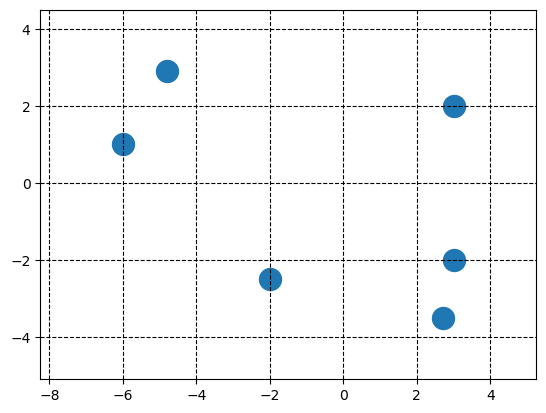

In [23]:
X_agnes = pd.read_csv('data/a2-agnes-toy-data.csv').to_numpy()

print(X_agnes)

plot_agnes_clustering([X_agnes])

To allow for a cleaner implementation of AGNES, you will implement it step by step using a collection of individual methods. To test these methods, let's create a dataset of 4 toy document vectors with two very simple clusters, each containing 2 document vectors. This allows you to easily verify if your implementation is correct.

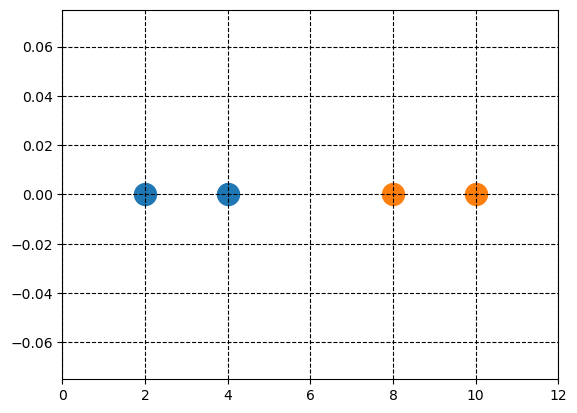

In [24]:
c1 = np.array([ [2, 0], [4, 0] ])
c2 = np.array([ [8, 0], [10, 0] ])

plot_agnes_clustering([c1, c2])

The method `merge_clusters()` we give you for free since it is too simple :). It merely takes two clusters, each represented by NumPy arrays and concatenates both arrays into a single array representing the newly merged cluster.

In [25]:
c_merged = MyAgglomerativeClustering().merge_clusters(c1, c2)

print(c_merged)

[[ 2  0]
 [ 4  0]
 [ 8  0]
 [10  0]]


We can, of course, now plot the merged cluster which now shows all 4 document vectors in the same color, as expected.

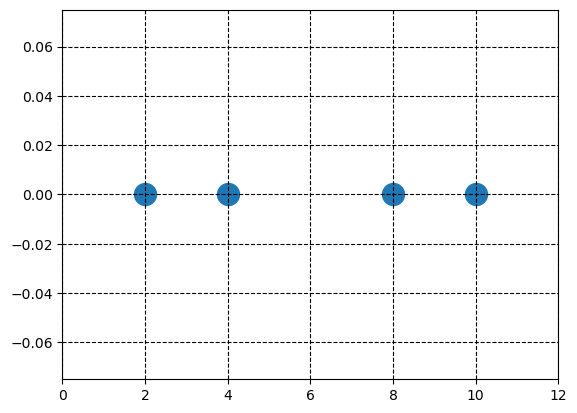

In [26]:
plot_agnes_clustering([c_merged])

#### 3.1 a) Calculating the Distances between 2 Clusters (2 Points)

Calculating the pairwise distances between the document vectors of two clusters actually requires the heavy lifting when calculating the similarity between two clusters. So with `euclidean_distances()` in place, the remaining step is very simple.

**Task: Implement the method `calculate_cluster_distance()` to calculate the distance between 2 clusters!** The skeleton of the method already calls method `euclidean_distances()` you have implemented earlier, so you only need to find the correct cluster distance with respect to the 3 supported linkage methods we covered in the lecture (*"single"*, *"complete"*, *"average"*).

In [27]:
print(MyAgglomerativeClustering(linkage="single").calculate_cluster_distance(c1, c2))    # Expected output: 4.0
print(MyAgglomerativeClustering(linkage="complete").calculate_cluster_distance(c1, c2))  # Expected output: 8.0
print(MyAgglomerativeClustering(linkage="average").calculate_cluster_distance(c1, c2))   # Expected output: 6.0

4.0
8.0
6.0


#### 3.1 b) Generating the Distance Matrix (3 Points)

Having a way to compute the distances between 2 clusters, we can now implement the method to compute the distances between n all pairs of clusters

**Task: Implement the method `generate_distance_matrix()` to calculate all pairwise distances between all clusters!** The input parameter `clustering` is a list of clusters (i.e., NumPy arrays); the result of this a matrix (a 2d NumPy array) containing the pairwise distances. Recall from the lecture that we only need to compute "half" of the matrix since the distance between two clusters `c1` and `c2` is naturally the same as between `c2` and `c1`. Also the diagonal of the matrix needs to remain $\infty$ (`np.Inf`) since the distance to a cluster to itself is 0 which would mess up the algorithm.

You can use the code cell below to test your implementation. Since there are only 2 clusters, the distance matrix is only a $2\times 2$ matrix, with only one value not being infinity.

In [28]:
print(MyAgglomerativeClustering(linkage="average").generate_distance_matrix([c1, c2]))

[[inf  6.]
 [inf inf]]


For `linkage"average"`, the expected output of the code cell above is

```
array([[inf,  6.],
       [inf, inf]])
```

Of course, for different linkage methods, the matrix will look different.

#### 3.1 c) Find all Clusterings (5 Points)

You have now implemented all the building blocks to compute the complete clustering hierarchy, i.e., all clusterings for each merge step.

**Task: Implement the method `fit()` to perform AGNES clustering!** The main steps needed here are simply (a) to find the pair of closest clusters and (b) to merge these to closest clusters to form a new clustering. This means, of course, that in each iteration, the number of clusters will decrease by 1, until we only have one cluster containing all document vectors left. At this point, the algorithm is done (cf. the condition for the `while` loop).

(Hint: the method [`np.unravel_index`](https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html) might come in handy; while not required, it should make your code snippet much shorter)

You can test your implementation with the code cell below. It plots the clusters after each calculation, where each cluster is represented by the document vectors of the same color. This means, of course, that in the first plot, all document vectors have a different color, while in the last plot, all document vectors have the same color.


In [6]:
X_agnes = np.array([[0, 0], [4, 0], [5, 0], [20, 0], [25, 0], [39, 0], [43, 0], [44, 0]])

In [13]:
my_agnes = MyAgglomerativeClustering(linkage="single").fit(X_agnes)
# my_agnes = MyAgglomerativeClustering(linkage="complete").fit(X_agnes)
# my_agnes = MyAgglomerativeClustering(linkage="average").fit(X_agnes)

for clustering in my_agnes.clustering_hierarchy[-2]:
    print(clustering)
    
#     plot_agnes_clustering(clustering)

[[0 0]
 [4 0]
 [5 0]]
[[20  0]
 [25  0]
 [39  0]
 [43  0]
 [44  0]]


### 3.2 Questions (9 points)

#### 3.2 a) Comparing Linkage Methods (3 Points)

Let's assume we have a dataset consisting of all integer numbers from 1 to 1,000 (i.e., we have a 1-dimensional dataset). We now want to cluster these numbers using AGNES, with the Euclidean Distance as our distance measure. The only additional rules, if 2 clusters have the same distance, we break the tie by selecting the two clusters that contain the smallest integer! For example, independent from the linkage method, we will always merge clusters (1) and (2) to cluster (1, 2) first; although clusters (44) and (45) have the same distance.

We cluster this dataset using the three Linkage methods *Single Linkage*, *Complete Linkage*, and *Average Linkage*. For each of the three Linkage methods, what are the sizes of the last 2 clusters to be merged -- that is, what is the number of elements (here: the integers) in the 2 clusters at the root of the resulting dendrograms. Provide a brief explanation for your answers!

**Your Answer:**


| Linkage Method | Size of 1st cluster | Size of 2nd cluster | Brief explanation |                                                            
|--- |--- |--- |--- |
| Single Linkage  | **999** | ***1*** | ***Here, since min distance is calculated, initially 1 and 2 are selected, then (1,2) and 3 are selected since min distance between clusters is 1 and finally (1...999) and 1000 are clustered*** |
| Complete Linkage  | ***512*** | ***488*** | <b>Here, since max distance is calculated, initially the clusters will be (1,2),(3,4)...(999,1000), then (1,2,3,4),(5,6,7,8)...and finally clusters (1,2..512) and (513,514..1000) are clustered</b> |
| Average Linkage  | ***512*** | ***488*** | ***Here, average distance is calulated and the clusters are formed as similar to complete linkage*** |

#### 3.2 b) Questions about K-Means (6 Points)

In the table below are 6 statements that are either True or False. Complete the table to specify whether a statement is True or False, and provide a brief explanation for your answer (Your explanation is more important than a simple True/False answer).

This is a markdown cell. Please fill in your answers for (1)~(6).

| No. | Statement                                                                                               	| True or False?   	| Brief Explanation |
|-----|------------------------------------------------------------------------------------------------------------|--------------| ------- |
| (1)  | When using K-Means++, then centroids are always at the position of existing data points | ***True*** | ***In K-means++, the centroid is selected from the data points***
| (2)  | K-Means++ ensures that the result will not include any empty clusters. | ***False*** | ***Duplicate values and if k > (number of unique data points) can cause empty clusters***
| (3)  | K-Means, independent of the initialization method, will always converge to a local minimum | ***True*** |  ***Since K-means is an iterative algorithm, it converges when the configuration doesn't change and the fixed configuration happens in local or gloabl optimum. Several random initialization are done to address this issue.*** |
| (4)  | K-Means++ will always converge to the global optimum. | ***False*** | ***It is not guaranteed that K-Means++ will achieve gloabl optimum***  |
| (5)  | K-Means++ initialization is more costly than a random initialization of the centroids but generally converges faster. | ***True*** | <b>Since, only one centroid is initialized, and then distance is calculated to all points to select the next centroid, it is computationally more expensive. However, based on multiple real world experiments, as shown in the original paper, it generally converges faster</b> |
| (6)  | K-Means is insensitive to data scaling (i.e., multiplying or dividing all numerical features by a constant value) -- that is, for the same $k$ and the same initial centroids, K-Means will yield the same clusters where the data is scaled or not. | ***False*** | ***If the centroids are also scaled, then it will yield same results, otherwise not*** |
| (7)  | K-Means is insensitive to data standardization (i.e., subtract mean, divide by standard deviation) -- that is, for the same $k$ and the same initial centroids, K-Means will yield the same clusters where the data is standardized or not. | ***False*** | ***K-Means is sensitive to data standardization, as the distance changes and hence the clustering assignment will also change accordingly*** |


---

## Summary

Distance-based methods are fundamental in text mining for tasks such as clustering and classification.

* Clustering involves grouping similar documents together based on their distance in a multidimensional space. Text documents are often represented as high-dimensional vectors, with each dimension corresponding to a term or word in the vocabulary. Techniques like k-means clustering or hierarchical clustering are commonly used to group documents based on their proximity in this vector space.

* K-nearest neighbors (KNN) classification is another distance-based method used in text mining. In KNN, a new document is classified based on the class labels of its nearest neighbors in the feature space. The class labels of the nearest neighbors are determined by measuring distances, often using metrics like Euclidean distance or cosine similarity.

Both clustering and KNN classification rely on the concept of distance or similarity between documents to make decisions about grouping or classification. These methods are powerful in text mining because they can handle large datasets and are relatively easy to implement. However, the choice of distance metric and the representation of text data can significantly impact the performance of these methods.